In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

%matplotlib inline

In [3]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
d = pd.read_csv('data_bank_models.csv')

In [6]:
d.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons_conf_idx,euribor_3_month,deposit
0,56,3,2,2,0,0,0,1,5,1,4.350000,1,999,0,0,-36.4,4.857,0
1,57,7,2,3,1,0,0,1,5,1,2.483333,1,999,0,0,-36.4,4.857,0
2,37,7,2,3,0,2,0,1,5,1,3.766667,1,999,0,0,-36.4,4.857,0
3,40,0,2,2,0,0,0,1,5,1,2.516667,1,999,0,0,-36.4,4.857,0
4,56,7,2,3,0,0,2,1,5,1,5.116667,1,999,0,0,-36.4,4.857,0


In [7]:
#dropping 'duration column as it is not needed now'
d.drop(columns = 'duration', inplace = True)

In [8]:
d.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'cons_conf_idx', 'euribor_3_month', 'deposit'],
      dtype='object')

In [9]:
d.shape

(41184, 17)

In [10]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41184 entries, 0 to 41183
Data columns (total 17 columns):
age                41184 non-null int64
job                41184 non-null int64
marital            41184 non-null int64
education          41184 non-null int64
default            41184 non-null int64
housing            41184 non-null int64
loan               41184 non-null int64
contact            41184 non-null int64
month              41184 non-null int64
day_of_week        41184 non-null int64
campaign           41184 non-null int64
pdays              41184 non-null int64
previous           41184 non-null int64
poutcome           41184 non-null int64
cons_conf_idx      41184 non-null float64
euribor_3_month    41184 non-null float64
deposit            41184 non-null int64
dtypes: float64(2), int64(15)
memory usage: 5.3 MB


In [11]:
#Changing pdays column to categorical o & 1
def prev_days(x):
    if x == 999:
        x = 0
    else:
        x = 1
    return x

In [12]:
#Changing previous column to categorical o & 1
def prev(x):
    if x == 0:
        x = 0
    else:
        x =1
    return x
    

In [13]:
# bucketing the age group:
def age_m(x):
    if x <= 32:
        x = 1
    elif (x > 32) &  ( x <= 47):
        x = 2
    elif (x > 47) & (x <= 70):
        x = 3
    elif (x > 70):
        x = 4
    
    return x

In [14]:
d['age_bucket'] = d.age.map(age_m)

In [15]:
d.age_bucket.unique()

array([3, 2, 1, 4], dtype=int64)

In [16]:
d.poutcome.unique()

array([0, 1, 2], dtype=int64)

In [17]:
#Changing the poutcome code to 1,2,3 from 0,1,2:
def change_code(x):
    if x == 0:
        x =1
    elif x ==1:
        x = 2
    elif x == 2:
        x = 3
    return x

In [18]:
d.poutcome = d.poutcome.map(change_code)

In [19]:
d.poutcome.unique()

array([1, 2, 3], dtype=int64)

In [20]:
#Feature engoineering: Combining pdays and previous columns as previous campaign info:
previous_campaign = []
for i in range(0,41184):
    if (d.pdays[i] == 999) & (d.previous[i] == 0):
        previous_campaign.append(0)
    else:
        previous_campaign.append(1)

In [21]:
len(previous_campaign)

41184

In [22]:
d['previous_campaign'] = previous_campaign

In [59]:
d.previous_campaign.value_counts()

0    35559
1     5625
Name: previous_campaign, dtype: int64

In [24]:
d.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'cons_conf_idx', 'euribor_3_month', 'deposit', 'age_bucket',
       'previous_campaign'],
      dtype='object')

In [60]:
d.corr()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,cons_conf_idx,euribor_3_month,deposit,age_bucket,previous_campaign
age,1.000000,0.001251,0.389734,-0.161195,0.165005,-0.001694,-0.007346,-0.007065,0.077263,-0.018532,0.004468,-0.034381,0.024384,0.026392,0.129366,0.010745,0.030419,0.910191,0.016397
job,0.001251,1.000000,-0.027852,0.114367,-0.028309,0.006982,-0.010236,0.025127,0.044803,-0.004977,-0.006917,-0.028457,0.020945,0.021103,0.052737,-0.007912,0.025102,-0.002734,0.014616
marital,0.389734,-0.027852,1.000000,-0.087581,0.079490,-0.010517,-0.005758,-0.054543,0.018721,-0.014521,0.007214,0.037930,-0.038668,-0.040395,0.033849,0.092005,-0.046181,0.379005,-0.035063
education,-0.161195,0.114367,-0.087581,1.000000,-0.208313,0.022568,0.010496,0.103720,0.112959,-0.003564,-0.001585,-0.019032,0.012232,0.018353,0.040410,-0.022484,0.027014,-0.142184,0.013567
default,0.165005,-0.028309,0.079490,-0.208313,1.000000,-0.015794,-0.003805,-0.135233,-0.084354,-0.004303,0.032867,0.080073,-0.102436,-0.108180,0.026514,0.195336,-0.099371,0.162479,-0.103970
housing,-0.001694,0.006982,-0.010517,0.022568,-0.015794,1.000000,0.044317,0.082208,0.031878,-0.009041,-0.011094,-0.010559,0.021330,0.023758,-0.033891,-0.059324,0.011567,0.000041,0.025175
loan,-0.007346,-0.010236,-0.005758,0.010496,-0.003805,0.044317,1.000000,0.008567,-0.004217,0.002371,0.005201,0.000354,-0.001343,-0.000482,-0.012034,0.000114,-0.004924,-0.002243,0.000103
contact,-0.007065,0.025127,-0.054543,0.103720,-0.135233,0.082208,0.008567,1.000000,0.324342,-0.019595,-0.077410,-0.117980,0.212866,0.226833,-0.251581,-0.399755,0.144788,-0.019682,0.242533
month,0.077263,0.044803,0.018721,0.112959,-0.084354,0.031878,-0.004217,0.324342,1.000000,-0.006944,-0.030672,-0.079549,0.063739,0.060825,0.264187,0.163364,0.037170,0.061046,0.043616
day_of_week,-0.018532,-0.004977,-0.014521,-0.003564,-0.004303,-0.009041,0.002371,-0.019595,-0.006944,1.000000,0.015142,0.006772,0.004002,0.003267,-0.000061,-0.005530,0.010040,-0.015291,0.007394


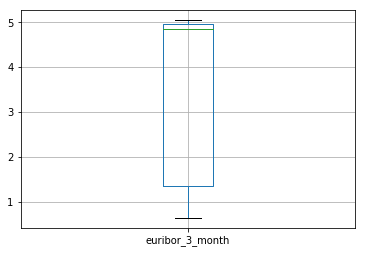

In [26]:
d.boxplot('euribor_3_month')

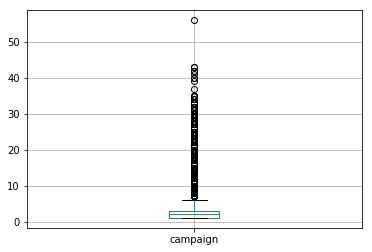

In [61]:
d.boxplot('campaign')

In [ ]:
#There was no subscription after 23 calls in current campaign so deleting those observations

In [62]:
d[(d.campaign >= 24) & (d.deposit == 1)].count()

age                  0
job                  0
marital              0
education            0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
cons_conf_idx        0
euribor_3_month      0
deposit              0
age_bucket           0
previous_campaign    0
dtype: int64

In [65]:
#Dropping those observations with more than 23 calls in current campaign
h = d[(d.campaign >= 24) & (d.deposit == 0)]

In [66]:
h.count()

age                  100
job                  100
marital              100
education            100
default              100
housing              100
loan                 100
contact              100
month                100
day_of_week          100
campaign             100
pdays                100
previous             100
poutcome             100
cons_conf_idx        100
euribor_3_month      100
deposit              100
age_bucket           100
previous_campaign    100
dtype: int64

In [67]:
d.drop(h.index, axis = 0, inplace = True)

In [75]:
d.shape

(41084, 19)

In [76]:
d.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'cons_conf_idx', 'euribor_3_month', 'deposit', 'age_bucket',
       'previous_campaign'],
      dtype='object')

In [70]:
d.to_csv('bank_marketing_for_feature_selection.csv', index = False)

In [ ]:
##Since potcome shows high correlation with previous campaign, will drop that for now, and remove pdays and previous as well

#### Modelling with all features, feature engineered ones and dropping the correlated ones

In [77]:
c = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign','previous_campaign',
       'cons_conf_idx', 'euribor_3_month',
       'age_bucket']

In [78]:
X = d[c]

In [79]:
X.corr()

,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous_campaign,cons_conf_idx,euribor_3_month,age_bucket
job,1.000000,-0.028510,0.114627,-0.028157,0.007076,-0.010315,0.025369,0.044877,-0.005323,-0.006730,0.014588,0.052774,-0.007832,-0.002773
marital,-0.028510,1.000000,-0.087487,0.079566,-0.010524,-0.005780,-0.054484,0.018847,-0.014298,0.008918,-0.035112,0.033771,0.092177,0.378805
education,0.114627,-0.087487,1.000000,-0.208382,0.022657,0.010497,0.103535,0.113062,-0.003627,-0.001559,0.013527,0.040463,-0.022414,-0.142421
default,-0.028157,0.079566,-0.208382,1.000000,-0.015896,-0.003799,-0.135302,-0.084350,-0.004059,0.036997,-0.104095,0.026486,0.195674,0.162628
housing,0.007076,-0.010524,0.022657,-0.015896,1.000000,0.044149,0.082444,0.031923,-0.009116,-0.013710,0.025229,-0.033923,-0.059480,-0.000128
loan,-0.010315,-0.005780,0.010497,-0.003799,0.044149,1.000000,0.008698,-0.004214,0.002274,0.009085,-0.000028,-0.012052,0.000357,-0.002193
contact,0.025369,-0.054484,0.103535,-0.135302,0.082444,0.008698,1.000000,0.324120,-0.019333,-0.076311,0.242516,-0.251854,-0.399845,-0.019910
month,0.044877,0.018847,0.113062,-0.084350,0.031923,-0.004214,0.324120,1.000000,-0.006929,-0.032253,0.043537,0.264517,0.163671,0.061086
day_of_week,-0.005323,-0.014298,-0.003627,-0.004059,-0.009116,0.002274,-0.019333,-0.006929,1.000000,0.012647,0.007618,0.000199,-0.005959,-0.015298
campaign,-0.006730,0.008918,-0.001559,0.036997,-0.013710,0.009085,-0.076311,-0.032253,0.012647,1.000000,-0.089803,-0.010535,0.134475,0.006116


In [80]:
y = d.deposit

In [81]:
X.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'previous_campaign',
       'cons_conf_idx', 'euribor_3_month', 'age_bucket'],
      dtype='object')

In [82]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [83]:
y.shape

(41084,)

In [84]:
Xs.shape

(41084, 14)

In [ ]:
#### Splitting train and test set and stratifying it on target

In [88]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=0, stratify = y)


In [89]:
print("Number Of Observations X_train dataset: ", X_train.shape)
print("Number Of Observations y_train dataset: ", y_train.shape)
print("Number Of Observations X_test dataset: ", X_test.shape)
print("Number Of Observations y_test dataset: ", y_test.shape)

Number Of Observations X_train dataset:  (28758, 14)
Number Of Observations y_train dataset:  (28758,)
Number Of Observations X_test dataset:  (12326, 14)
Number Of Observations y_test dataset:  (12326,)


In [90]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 3248
Before OverSampling, counts of label '0': 25510 



In [157]:
#### Goal is to look at model with high recall rate

In [91]:
sm = SMOTE(random_state=2)
X_train_resample, y_train_resample = sm.fit_sample(X_train, y_train.ravel())

In [92]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_resample.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_resample.shape))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_resample==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_resample==0)))

After OverSampling, the shape of train_X: (51020, 14)
After OverSampling, the shape of train_y: (51020,) 

After OverSampling, counts of label '1': 25510
After OverSampling, counts of label '0': 25510


In [ ]:
#Now the base accuracy is 50%

In [93]:

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_resample, y_train_resample.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    3.3s finished
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [94]:
clf.best_params_

{'C': 1.0}

In [96]:
clf.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [97]:
lr1 = LogisticRegression(C=1, verbose=0)
lr1.fit(X_train_resample, y_train_resample.ravel())

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [98]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [99]:
# #On training data original, checking the values:
# y_train_pre = lr1.predict(X_train)

# cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

# print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


# class_names = [0,1]
# plt.figure()
# plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
# plt.show()

Recall metric in the testing dataset: 68.46264367816092%


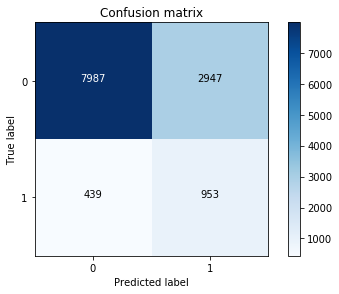

In [115]:
#predicting on test set
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [116]:
print(confusion_matrix(y_test, y_pre))

[[7987 2947]
 [ 439  953]]


In [117]:
print(classification_report(y_test, y_pre))

              precision    recall  f1-score   support

           0       0.95      0.73      0.83     10934
           1       0.24      0.68      0.36      1392

   micro avg       0.73      0.73      0.73     12326
   macro avg       0.60      0.71      0.59     12326
weighted avg       0.87      0.73      0.77     12326



In [103]:
#On sampled data
tmp = lr1.fit(X_train_resample, y_train_resample.ravel())

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


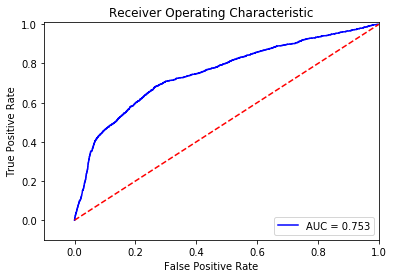

In [118]:
#after training resample, checking on original test set
y_pred_sample_score = tmp.decision_function(X_test)

y_pred_sample = lr1.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [119]:
print(classification_report(y_test, y_pred_sample))

              precision    recall  f1-score   support

           0       0.95      0.73      0.83     10934
           1       0.24      0.68      0.36      1392

   micro avg       0.73      0.73      0.73     12326
   macro avg       0.60      0.71      0.59     12326
weighted avg       0.87      0.73      0.77     12326



In [120]:
tmp.score(X_test, y_test)

0.7252961220184975

In [108]:
bg = BaggingClassifier(n_estimators=100)
cross_val_score(bg, X_train_resample, y_train_resample, cv = 5)

array([0.76793414, 0.96756174, 0.96648373, 0.96520972, 0.96628773])

In [110]:
bg.fit(X_train_resample, y_train_resample.ravel())

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [111]:
yhat = bg.predict(X_test)

In [112]:
bg.score(X_test, y_test)

0.8768456920331008

In [113]:
confusion_matrix(y_test, yhat)

array([[10354,   580],
       [  938,   454]], dtype=int64)

In [114]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     10934
           1       0.44      0.33      0.37      1392

   micro avg       0.88      0.88      0.88     12326
   macro avg       0.68      0.64      0.65     12326
weighted avg       0.86      0.88      0.87     12326



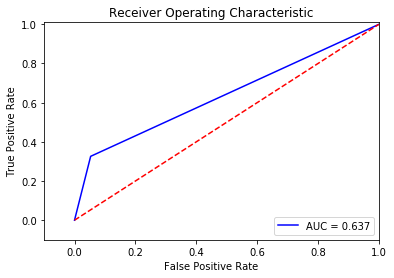

In [121]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [121]:
dt = DecisionTreeClassifier()
cross_val_score(dt, X_train_resample, y_train_resample, cv = 5)

array([0.74945941, 0.93198349, 0.93129546, 0.92911915, 0.92587495])

In [217]:
dt.fit(X_train_resample, y_train_resample)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [218]:
yhat1 = dt.predict(X_test)

In [219]:
dt.score(X_test, y_test)

0.8396884634106766

In [220]:
confusion_matrix(y_test, yhat1)

array([[9892, 1042],
       [ 934,  458]], dtype=int64)

In [221]:
print(classification_report(y_test, yhat1))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     10934
           1       0.31      0.33      0.32      1392

   micro avg       0.84      0.84      0.84     12326
   macro avg       0.61      0.62      0.61     12326
weighted avg       0.85      0.84      0.84     12326



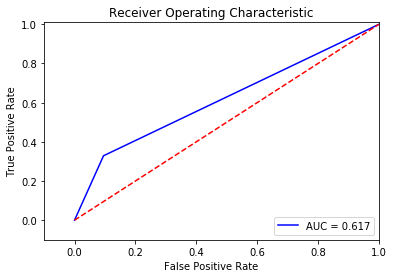

In [222]:
fpr, tpr, thresholds = roc_curve(y_test, yhat1)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [122]:
rf2 = RandomForestClassifier()
cross_val_score(rf2, X_train_resample, y_train_resample, cv = 5)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

array([0.78008624, 0.96462172, 0.96707174, 0.96364171, 0.9630537 ])

In [123]:
rf2.fit(X_train_resample, y_train_resample)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [124]:
rf2.score(X_test, y_test)

0.8762777867921466

In [125]:
yhat2 = rf2.predict(X_test)

In [126]:
confusion_matrix(y_test, yhat2)

array([[10381,   553],
       [  972,   420]], dtype=int64)

In [127]:
print(classification_report(y_test, yhat2))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     10934
           1       0.43      0.30      0.36      1392

   micro avg       0.88      0.88      0.88     12326
   macro avg       0.67      0.63      0.64     12326
weighted avg       0.86      0.88      0.87     12326



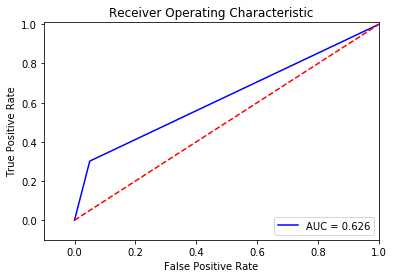

In [215]:
fpr, tpr, thresholds = roc_curve(y_test, yhat2)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [128]:
from xgboost import XGBClassifier

In [129]:
xg = XGBClassifier()

In [130]:
cross_val_score(xg, X_train_resample, y_train_resample, cv = 5)

array([0.75411603, 0.93502548, 0.93296746, 0.93923951, 0.93228146])

In [131]:
xg.fit(X_train_resample, y_train_resample)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [132]:
xg.score(X_test, y_test)

0.8753042349505111

In [133]:
yhatx = xg.predict(X_test)

In [134]:
confusion_matrix(y_test, yhatx)

array([[10152,   782],
       [  755,   637]], dtype=int64)

In [135]:
print(classification_report(y_test, yhatx))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10934
           1       0.45      0.46      0.45      1392

   micro avg       0.88      0.88      0.88     12326
   macro avg       0.69      0.69      0.69     12326
weighted avg       0.88      0.88      0.88     12326



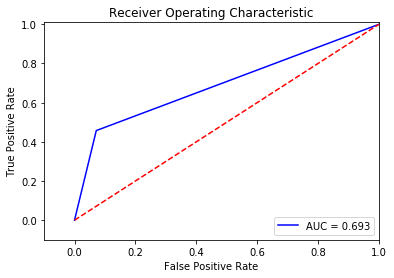

In [136]:
fpr, tpr, thresholds = roc_curve(y_test, yhatx)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
##taking euribor, job, campaign, day of week, agebucket, education, marital, consconfi, housing, month pdays previous

In [137]:
sv = LinearSVC()

In [138]:
cross_val_score(sv, X_train_resample, y_train_resample, cv =10)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

array([0.72167777, 0.73304586, 0.72265778, 0.7244218 , 0.72285378,
       0.7252058 , 0.72422579, 0.70893767, 0.71677773, 0.72696982])

In [139]:
sv.fit(X_train_resample, y_train_resample)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [140]:
yhatc = sv.predict(X_test)

In [141]:
sv.score(X_test, y_test)

0.7189680350478663

In [142]:
confusion_matrix(y_test, yhatc)

array([[7903, 3031],
       [ 433,  959]], dtype=int64)

In [143]:
print(classification_report(y_test, yhatc))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     10934
           1       0.24      0.69      0.36      1392

   micro avg       0.72      0.72      0.72     12326
   macro avg       0.59      0.71      0.59     12326
weighted avg       0.87      0.72      0.77     12326



In [144]:
score_pred_y = sv.decision_function(X_test)

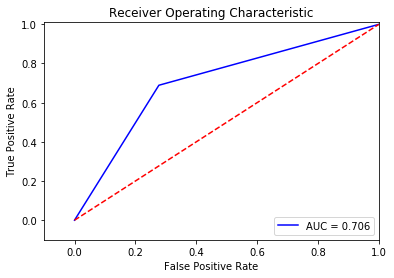

In [145]:
fpr, tpr, thresholds = roc_curve(y_test, yhatc)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [184]:
knn = KNeighborsClassifier()
cross_val_score(knn, X_train_resample, y_train_resample, cv =5)

array([0.86005488, 0.86152489, 0.86025088, 0.8620149 , 0.86779694])

In [185]:
knn.fit(X_train_resample, y_train_resample)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [186]:
knn.score(X_test, y_test)

0.754097030666883

In [187]:
yhatk = knn.predict(X_test)

In [188]:
confusion_matrix(y_test, yhatk)

array([[8563, 2371],
       [ 660,  732]], dtype=int64)

In [189]:
print(classification_report(y_test, yhatk))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85     10934
           1       0.24      0.53      0.33      1392

   micro avg       0.75      0.75      0.75     12326
   macro avg       0.58      0.65      0.59     12326
weighted avg       0.85      0.75      0.79     12326



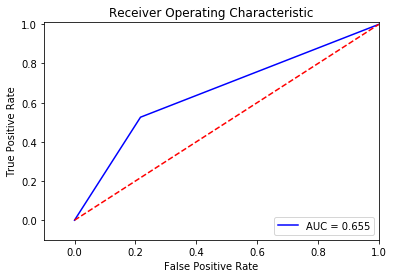

In [190]:
fpr, tpr, thresholds = roc_curve(y_test, yhatk)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [148]:
from sklearn.naive_bayes import GaussianNB

In [149]:
gb = GaussianNB()

In [150]:
cross_val_score(gb, X_train_resample, y_train_resample, cv = 10)

array([0.69835359, 0.71148569, 0.71109369, 0.70207762, 0.70972168,
       0.71070169, 0.70188162, 0.69345355, 0.68953352, 0.70815367])

In [151]:
gb.fit(X_train_resample, y_train_resample)

GaussianNB(priors=None, var_smoothing=1e-09)

In [152]:
yhatg = gb.predict(X_test)

In [153]:
gb.score(X_test, y_test)

0.6889501865974363

In [154]:
confusion_matrix(y_test, yhatg)

array([[7517, 3417],
       [ 417,  975]], dtype=int64)

In [155]:
print(classification_report(y_test, yhatg))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     10934
           1       0.22      0.70      0.34      1392

   micro avg       0.69      0.69      0.69     12326
   macro avg       0.58      0.69      0.57     12326
weighted avg       0.87      0.69      0.74     12326



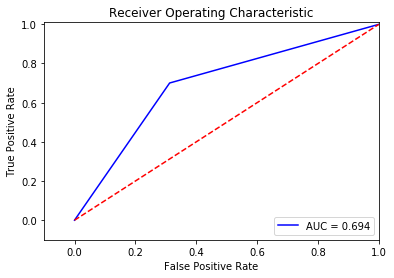

In [156]:
fpr, tpr, thresholds = roc_curve(y_test, yhatg)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [158]:
# #Though the recall score Will try feature selection to see good pred

In [166]:
d.to_csv('bank_marketing_data_feature_engineered.csv', index = False)

In [165]:
d.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'cons_conf_idx', 'euribor_3_month',
       'deposit', 'age_bucket', 'previous_campaign'],
      dtype='object')